<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1">Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2">Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3">Тестирование</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.1">Логистическая регрессия</a></span></li><li><span><a href="#Линейный-классификатор-со-стохастическим-градиентным-спуском" data-toc-modified-id="Линейный-классификатор-со-стохастическим-градиентным-спуском-3.2">Линейный классификатор со стохастическим градиентным спуском</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4">Выводы</a></span><ul class="toc-item"><li><span><a href="#Финальный-результат:" data-toc-modified-id="Финальный-результат:-4.1">Финальный результат:</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5">Чек-лист проверки</a></span></li></ul></div>

# Toxic comments

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Импортируем необходимые библиотеки   
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
import re

from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('toxic_comments.csv')

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Изучим данные на пропуски, типы, посмотрим как они выглядят   
</div>

In [3]:
df.info()
display(df.head(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Перед нами информация по 159571 комментарию на английском языке. Все комментарии имеют разметку 1 или 0, в зависимости от их токсичности:
- 1 - Токсичный
- 0 - Нормальный

Посмотрим на соотношения количества этих комментариев на графике
</div>

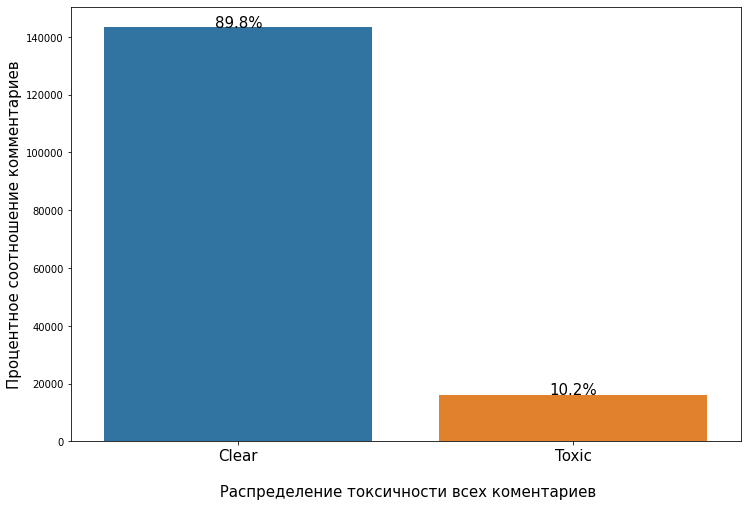

In [4]:
rcParams['figure.figsize'] = 12, 8
def make_countplot(data,message):
    try:
        ax = sns.countplot(data['toxic'])
    except:
        ax = sns.countplot(data)
    plt.xlabel(f'\n Распределение токсичности {message}', fontsize = 15)
    ax.set_xticklabels(["Clear", "Toxic"], fontsize = 15)
    plt.ylabel("Процентное соотношение комментариев", fontsize = 15)

    total = float(len(data))
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() - 0.4 + p.get_width()
        y = p.get_height()
        ax.annotate(percentage, (x, y),ha='center', fontsize=15)
    plt.show()
    
make_countplot(df, 'всех коментариев')

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Перед нами явный дисбаланс комментариев. Токсичные составляют чуть больше 10% от общего количества. Это похоже на реальные данные, судя по статистике токсичности комментариев. Хотя, судя по моему почтовому ящику, должно быть наоборот 🤣
    
Язык этих комментариев - английский. Следующим шагом лемматизируем текст и уберём лишние символы и знаки, которые могут помешать нашей модели обучаться на данных. Для Лемматизации используем морфологический анализатор <code>Mystem</code> из библиотеки <code>pymystem3</code>. Для очистки исопльзуем модуль <code>re</code>
    
После лемматизации и очистки, запишем полученное в новый столбец <code>lemm_text</code> и удалим старый <code>text</code>.
</div>

In [ ]:
%%time

m = Mystem()

def lemmatize_text(text):
    text = text.lower()
    lemm_text = "".join(m.lemmatize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

df['lemm_text'] = df['text'].apply(lemmatize_text)

df = df.drop(['text'], axis=1)
del m

<div class="alert alert-block alert-info">
<b>Совет: </b> Этот лемматизатор работает только с расским языком, так что его нет смысла применять.
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Очистку желательно было провести до лемматизации.
</div>

<div class="alert alert-block alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid "> 
<b>Комментарий студента №1 :</b>
    
Понял
</div>

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Посмотрим что у нас получилось
</div>

In [ ]:
df['lemm_text']

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Для обучения модели разобьём датасет на 3 выборки: Обучающую(60%), Валидационную(20%) и Тестовую(20%); этого должно хватить. Сделаем это таким образом, чтобы в выборках сохранялась пропорция токсичных и нормальных комментариев за счет параметра <code>stratify</code>
Далее в фичах переведём лемматизированный текст к типу Юникод и расставим веса с помощью <code>TfidfVectorizer</code> и <code>nltk</code>. Отобразим размерность выборок и построим графики, чтобы убедиться, что распределение комментариев везде одинаковое.
</div>

In [ ]:
target = df['toxic']
features = df.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.3,
                                                                              stratify=target,
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            stratify=target_valid,
                                                                            random_state=12345)

In [ ]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

In [ ]:
%%time

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values.astype('U'))
features_valid = count_tf_idf.transform(features_valid['lemm_text'].values.astype('U'))
features_test = count_tf_idf.transform(features_test['lemm_text'].values.astype('U'))

In [ ]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

In [ ]:
make_countplot(target_train, 'на тренировочной выборке')

In [ ]:
make_countplot(target_valid, 'на валидационной выборке')

In [ ]:
make_countplot(target_test, 'на тестовой выборке')

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Чтобы определиться с выбором модели, возьмём модель Логистической регрессии, проведём кроссвалидацию и посмотрим на параметр f1. Исходя из этого результата будем решать, подходит ли самая простая модель для решения поставленной задачи или нет.
</div>

In [ ]:
%%time

model = LogisticRegression()
train_f1 = cross_val_score(model, 
                           features_train, 
                           target_train, 
                           cv=3, 
                           scoring='f1').mean()
print(f'F1 на CV {train_f1}')

<div class="alert alert-block alert-info">
<b>Совет: </b> Напомню, что внутри кросс-валидации происходит разбиение выборки на треин и валидацию. Однако, в таком случае векторизатор обучен на всей выборке, а это не совсем корректно. Для избежания такого эффекта можно использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">пайплайн</a>. <a href="https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05">Тут</a> есть пример.
</div>

<div class="alert alert-block alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid "> 
<b>Комментарий студента № :</b>
    
Не совсем понял. Он же обучается на всей обучающей выборке (70% от общей) так и надо же вроде. Я ведь не затрагиваю тренировочную выборку
</div>

<div class="alert alert-block alert-info">
<b>Совет (ревью 2): </b> Да, но ведь при обучении векторизатора ты затрагиваешь всю выборку, а не только эти 70% (на самом деле 66%, то есть 2/3).

1. Внутри кросс-валидации происзодит разбиение переданной в нее выборку на части (треин и валидация). Подробнее тут: https://codecamp.ru/blog/cross-validation-k-fold/
2. Мы хотим, чтобы при подборе параметров внутри кросс-валидации векторизатор не обучался на валидации. Для этого нам нужно его обучать каждый раз только на треине (внутри кросс-валидации). Для этого и нужен пайплайн, чтобы внутри кросс-валидации обучалась не только модель, но и векторизатор. 

Вот такой пайплайн нужно передать в кросс-валидацию:  
`pipe_lr = Pipeline([(‘vect’, CountVectorizer()),
 (‘tfidf’, TfidfTransformer()),
 (‘model’, LogisticRegression())])`
    
Тут подробнее про то, как тюнить параметры у пайплайна: https://stackoverflow.com/questions/51606341/hyper-parameter-tuning-on-pipeline-object
</div>

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Принято решение использовать модель Логистической регрессии по 2 причинам:
    - Без подбора гиперпараметров модель показывает относительно высокий f1
    - Модель быстро считает большой объём информации. Скорее всего, модели деревьев и лесов будут решать подобную задачу дольше и это будет неприемлимо для бизнеса. По причине того, что реагировать на токсичность комментариев необходимо максимально быстро и быстро принимать решение о модерации, бане комментатора или других действий.
    
Попробуем 3 варианта борьбы с дисбалансом классов:
1. Пропишем для модели веса классов вручную
2. Зададим вложенной функцией <code>class_weight='balanced'</code>
3. Произведём даунсемплинг большего класса - нулей.
</div>

## Обучение

In [ ]:
%%time
class_ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
dict_classes={0:1, 1:class_ratio}
model = LogisticRegression(class_weight=dict_classes)
train_f1_ballanced = cross_val_score(model, 
                                     features_train, 
                                     target_train, 
                                     cv=3, 
                                     scoring='f1').mean()
print(f'F1 на CV со сбалансированными классами {train_f1_ballanced}')

In [ ]:
%%time

model = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(model, 
                                    features_train, 
                                    target_train, 
                                    cv=3, 
                                    scoring='f1').mean()
print(f'F1 на CV со сбалансированными классами {train_f1_ballanced}')

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Использовать сбалансированные классы двумя разными подходами нет необходимости, результат получается одинаковый
    
Проведём ресемплирование
</div>

In [ ]:
# Создадим новый датафрейн из исходного, выбрав комментарии из обучающей выборки
df_train = df.iloc[target_train.index]

# Разделим на нули и единицы
target_train_class_zero = df_train[df_train['toxic'] == 0]['toxic']
target_train_class_one = df_train[df_train['toxic'] == 1]['toxic']

In [ ]:
%%time

# Возьмём одинаковое количество нулей и единиц
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12345)
# Объединим их, создав таким образом сбалансированную обучающую выборку
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

# Выберем фичи из исходного датафрейма, выбрав комментарии из таргета
features_train_downsample = df.iloc[target_train_downsample.index]

# Хорошенько всё перемешаем
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12345)
# Приведём всё к формату юникода, расставим веса и удалим ненужные переменные
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text'].values.astype('U'))
del count_tf_idf
del stopwords

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Посмотрим на баланс классов
</div>

In [ ]:
make_countplot(target_train_downsample, 'на тестовой выборке')

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Самое время сделать кросс-валидацию на ресемплированных тренировочных данных и посмотреть на метрику f1
</div>

In [ ]:
%%time
model = LogisticRegression()
train_f1_downsampled = cross_val_score(model,
                                       features_train_downsample, 
                                       target_train_downsample, 
                                       cv=3, 
                                       scoring='f1').mean()
print(f'F1 на CV с уменьшением классов {train_f1_downsampled}')

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Построим Roc-Auc кривую для 3 моделей: 
- Логистическая регрессия
- Логистическая регрессия со сбалансированными классами
- Логистическая регрессия с даунсеплингом классов

</div>

In [ ]:
%%time

plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Константная модель')


model = LogisticRegression()
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, model.predict(features_valid))
plt.plot(fpr, tpr, label='Логистическая регрессия')

model = LogisticRegression(class_weight=dict_classes)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(target_valid, model.predict(features_valid))
plt.plot(fpr, tpr, label='Логистическая регрессия со сбалансированными классами')

model = LogisticRegression()
model.fit(features_train_downsample,target_train_downsample)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_downsampled = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_downsampled = f1_score(target_valid, model.predict(features_valid))
plt.plot(fpr, tpr, label='Логистическая регрессия с даунсеплингом')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая", fontsize = 15)
plt.show()

In [ ]:
index = ['Логистическая регрессия',
         'ЛР со сбалансированными классами',
         'ЛР с даунсемплингом']
results = {'F1 на CV':[train_f1,
                    train_f1_balanced,
                    train_f1_downsampled],
        'F1 на валидации':[valid_f1,
                           valid_f1_balanced,
                           valid_f1_downsampled],
        'AUC-ROC':[auc_roc,
                   auc_roc_balanced,
                   auc_roc_downsampled]}

scores_data = pd.DataFrame(data=results, index=index)
scores_data

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

По результатам обучения модели Логистической регрессии с различными балансами был отобран лучший вариант предобработки данных - баланс классов. Теперь более тонко подберём гиперпараметры, проверим на валидационной выборке. В случае успеха перейдём на тестовую выборку, посчитаем f1 на тесте и отобразим результат на roc-кривой

</div>

## Тестирование

<div class="alert alert-block alert-info">
<b>Совет: </b> На этапе тестирования измеряют качетсво лучшей модели. Лучше было сделать отдельный шаг "подбор параметров".
</div>

<div class="alert alert-block alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid "> 
<b>Комментарий студента № :</b>
    
После отправки проекта в следующую секунду понял, что надо было выделить шаги по подбору параметров отдельно. Было уже 3 ночи, плохо соображал.
    
</div>

### Логистическая регрессия

In [ ]:
%%time

model = LogisticRegression()
params = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


clf = GridSearchCV(model, params, scoring='f1',cv=3)
clf.fit(features_train, target_train)
best_params = clf.best_params_

print("Лучшие гиперпараметры: \n")
print(best_params, '\n')

f1_cv = max(means)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

В результате подбора гиперпараметров и кросс-валидации получен лучший вариант модели и её гиперпараметров под текущую задачу. Обучаем и проверяем эту модель на валидационной выборке.

</div>

In [ ]:
%%time

model = LogisticRegression()
model.set_params(**best_params)
model.fit(features_train, target_train)
target_predict = model.predict(features_valid)
valid_f1 = f1_score(target_valid, target_predict)
print(f'F1 на кросс-валидации', f1_cv)
print(f'F1 на валидации {f1_valid}')

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Успех. Мы добились значения метрики f1 выше 0.75. Это значит, что модель нас полностью устраивает. Данных для предсказания много и модель довольно быстро с ними справляется. Можно переходить к тестировке.
</div>

In [ ]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = model.predict(features_test)

print('Метрики Логистической регрессии')
print(f'ROC AUC: {roc_auc_score(target_test, probabilities_one_test)}')
print(f'F1: {f1_score(target_test, predict_test)}')
print(f'Precision: {precision_score(target_test, predict_test)}')
print(f'Recall: {recall_score(target_test, predict_test)}', )
print(f'Accuracy: {accuracy_score(target_test, predict_test)}')
print()
print('Отчёт')
print()
print(classification_report(target_test, predict_test))

cm = confusion_matrix(target_test, predict_test)

sns.heatmap(cm, annot=True, fmt='d', cmap="BrBG_r")
plt.xlabel('Предсказания на тесте', fontsize = 15)
plt.ylabel('Тестовая выборка', fontsize = 15)
plt.title('Матрица ошибок Линейной Регрессии', fontsize = 15)
plt.show()

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Успех. Мы добились значения метрики f1 выше 0.75. Строим финальную кривую, сравниваем полученный результат с константной моделью, пишем вывод.
</div>

In [ ]:
plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle='--', label='Константная модель')
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot(fpr, tpr, label='Логистическая регрессия')
plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая", fontsize = 15)
plt.show()

### Линейный классификатор со стохастическим градиентным спуском

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Рассмотрим ещё одну модель классификации. Также укажем для неё сбалансированные классы и подберём дополнительные гиперпараметры.

</div>

In [ ]:
%%time

sgdc = SGDClassifier()
params = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[12345],
                'class_weight':[dict_classes]}]


clf = GridSearchCV(sgdc, params, scoring='f1',cv=3)
clf.fit(features_train, target_train)
sgdc_best_params = clf.best_params_
print("Лучшие гиперпараметры: \n")
print(sgdc_best_params)

sgdc_cv_f1 = max(means)

In [ ]:
%%time

sgdc = SGDClassifier()
sgdc.set_params(**sgdc_best_params)
sgdc.fit(features_train, target_train)
target_predict = sgdc.predict(features_valid)
sgdc_valid_f1 = f1_score(target_valid, target_predict)
print(f'F1 на cv {sgdc_cv_f1}')
print(f'F1 на валидации {sgdc_valid_f1}')

In [ ]:
probabilities_test = sgdc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = sgdc.predict(features_test)

print('Метрики SGDClassifier регрессии')
print(f'ROC AUC: {roc_auc_score(target_test, probabilities_one_test)}')
print(f'F1: {f1_score(target_test, predict_test)}')
print(f'Precision: {precision_score(target_test, predict_test)}')
print(f'Recall: {recall_score(target_test, predict_test)}', )
print(f'Accuracy: {accuracy_score(target_test, predict_test)}')
print()
print('Отчёт')
print()
print(classification_report(target_test, predict_test))

cm = confusion_matrix(target_test, predict_test)

sns.heatmap(cm, annot=True, fmt='d', cmap="BrBG_r")
plt.xlabel('Предсказания на тесте', fontsize = 15)
plt.ylabel('Тестовая выборка', fontsize = 15)
plt.title('Матрица ошибок SGDClassifier', fontsize = 15)
plt.show()

In [ ]:
plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle='--', label='Константная модель')
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot(fpr, tpr, label='SGDClassifier')
plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая", fontsize = 15)
plt.show()

## Выводы

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

В ходе проделанного проекта была построена успешная модель предсказания токсичности комментариев для компании «Викишоп».
    
Задача бизнеса: Научиться быстро реагировать на токсичные комментарии пользователей и своевременно пресекать эти комментарии/этих пользователей.
    
Успешность модели оцнивается по метрике f1
    
<hr>
    
В результате анализа и подготовки данных было установлено и проделано следующее:
    
- Данные представляют собой набор из более 150 тысяч англоязычных размеченных комментариев. Они разбиты на 2 категории: 
<blockquote>    
0 - Комментарий нормальный; <br>
1 - Комментарий токсичный.
</blockquote> 
- В данных отсутствуют пропуски и отклонения;
- Соотношение классов: 0 - 90%, 1 - 10%;
- Произведена лемматизация текстов
- Данные поделены на обучающую, валидационную и тестовую выборки (60/20/20)
- Все тексты были переведены в вектора с определёнными весами и приведены к типу Юникод
    
Для борьбы с дисбалансом было применено 3 стратегии:
<blockquote>    
- Без борьбы с дисбалансом; <br>
- Со сбалансированными классами. <br>
- С применением даунсемплинга к наибольшему классу. <br>
</blockquote>
    
В результате проверки тренировочной выборки на кроссвалидации лучшим вариантом борьбы с дисбалансом оказалась модель с применением даунсемплинга на тренировочной выборке. Но проверка на валидационной выборке показала, что лучше справляется модель со сбалансированными классами. Ниже изображён график roc-кривой, по которой видно, что модель со сбалансированными класами лучше справляется с предсказанием на валидационной выборке
    
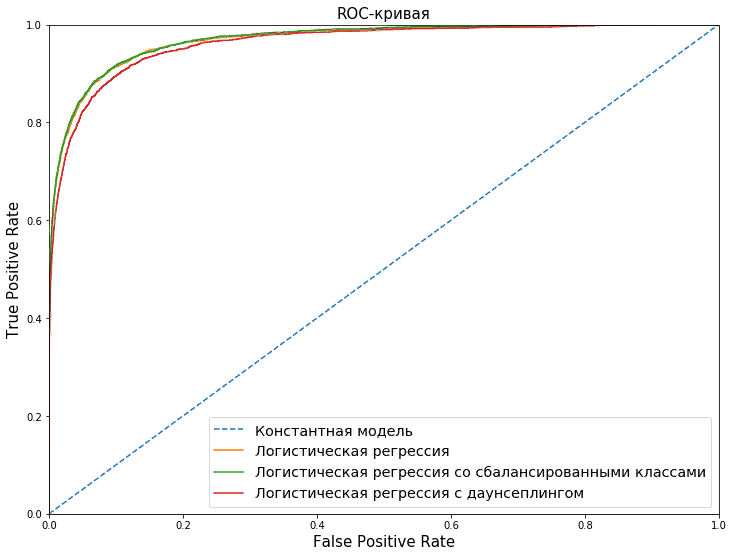
    
<hr>
    
При помощи GridSearchCV на тестовой выборке был произведён подбор гиперпараметров для модели Логистической регрессии. 

При валидации наша модель с подобранными гиперпараметрами показала f1 выше 0.75.
    
<hr>

На финальном этапе тестирования модель Линейной регрессии показала <b>F1 = 0.77</b>
    
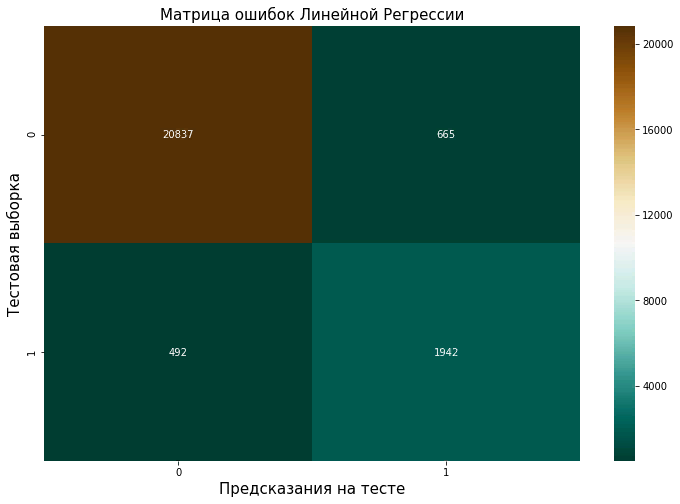
    
    
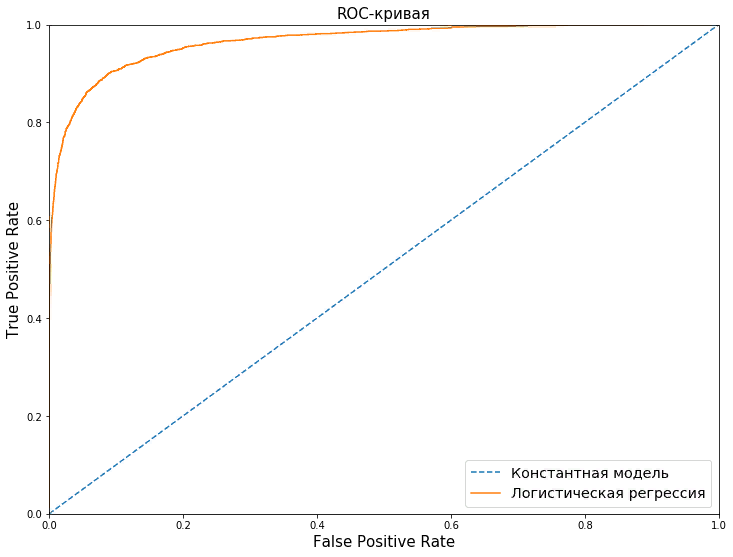
    
    
    
<hr>
    
    
    
Также была обучена модель SGDClassifier - Линейный классификатор со стохастическим градиентным спуском
На финальном этапе тестирования модель показала <b>F1 = 0.766</b>
    
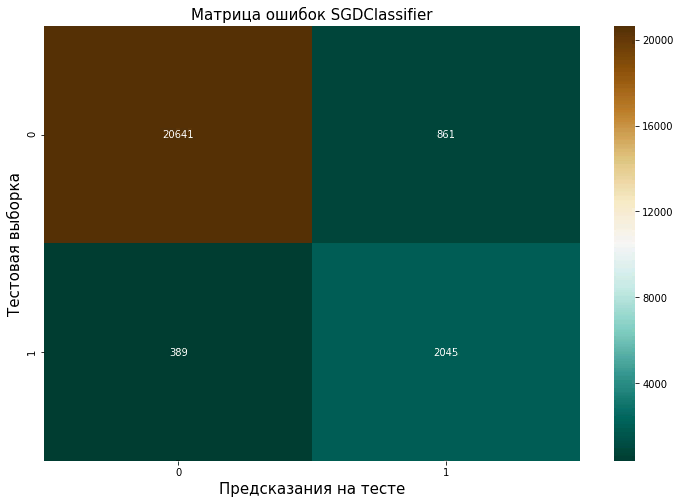
    
    
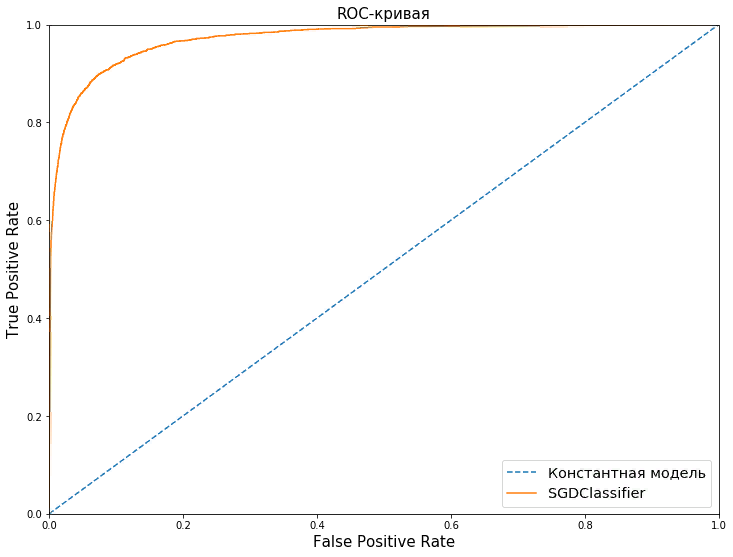
    
<hr>
    
    
### Финальный результат:
    
|Модель|	F1 на тесте|
|:--|:--:|
LogisticRegression|	0.7705|
SGDClassifier|	0.7659|
    
    
    
</div>